# Homework 1 (Due Feb. 10, 2023 at Noon) 

Submit your solution notebook in your directory via github PR.

## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process i.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astropy.visualization import hist
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

In [3]:
# define a straight line
def line(a, b, x):
    return a*x + b

# this calculates the z-scaled residual 
def zres(a, b, x, y, dy=1.):
    z = (y - line(a, b, x))/dy
    return z
    
# Define a standard squared-loss function
def squared_loss(a, b, x, y, dy=1.):
    # we'll add the extra 1/2 just to make the scaling the same as the Huber loss - just a constant
    z = zres(a, b, x, y, dy)
    return np.sum(z**2.)/2. 

# Define the Huber loss function
def huber_loss(a, b, x, y, dy=1., delta=1.):
    assert delta > 0., "keep your deltas positive"
    z = zres(a, b, x, y, dy)
    zabs = np.abs(z)
    loss = zabs*0.
    ind_out = (zabs > delta)
    loss[ind_out] = delta*zabs[ind_out] - delta**2./2.
    loss[~ind_out] = z[~ind_out]**2./2
    return np.sum(loss)

In [4]:
# next we need a grid of a, b
# you can figure out reasonable values in different ways
# you have the data, so you can simply compute the equation of a line picking a couple of reasonable points
# some of you said you are used to np.polyfit which takes the x, and y values but no errors
# i.e. it's loss function is just the sum of squared residuals, no dy included
# it can however evaluate the Fisher matrix at the minimum of that loss, and return uncertainties in the slope that way
p, cov = np.polyfit(x, y, deg=1, cov=True)
slope_guess, intercept_guess = p

# the diagonal elements of the covariance matrix tell you about the variance in the slope and intercept respectively
err_slope = np.sqrt(cov[0][0])
err_intercept = np.sqrt(cov[1][1])


# so lets evaluate on a grid of guess +/- 5 sigma (this is excessive, but whatever) and we'll do a 500 points 
a_range = np.arange(slope_guess - 5.*err_slope, slope_guess + 5.*err_slope, err_slope/50.)
b_range = np.arange(intercept_guess - 5.*err_intercept, intercept_guess + 5.*err_intercept, err_intercept/50.)


# finally we need something to evaluate our loss functions on this grid
def eval_loss_func(x, y, dy, a_range, b_range, loss_func):
    
    # we need something to store the loss values for each a, b
    loss = np.ones((len(a_range), len(b_range)) )* np.nan

    # and then we evaluate it - this takes seconds - note this is a really inefficient approach
    for i, a in enumerate(a_range):
        for j, b in enumerate(b_range):
            loss[i][j] = loss_func(a, b, x, y, dy)

    # the minimum loss is at 
    imin = loss.argmin()
    # that's going to give you a single index for a flat array, but you can get the index in both dimensions easily
    i_a, i_b =np.unravel_index(imin, loss.shape)
    
    a_best_fit = a_range[i_a]
    b_best_fit = b_range[i_b]
    return a_best_fit, b_best_fit, loss, i_a, i_b

Optimization terminated successfully.
         Current function value: 43.439758
         Iterations: 61
         Function evaluations: 113


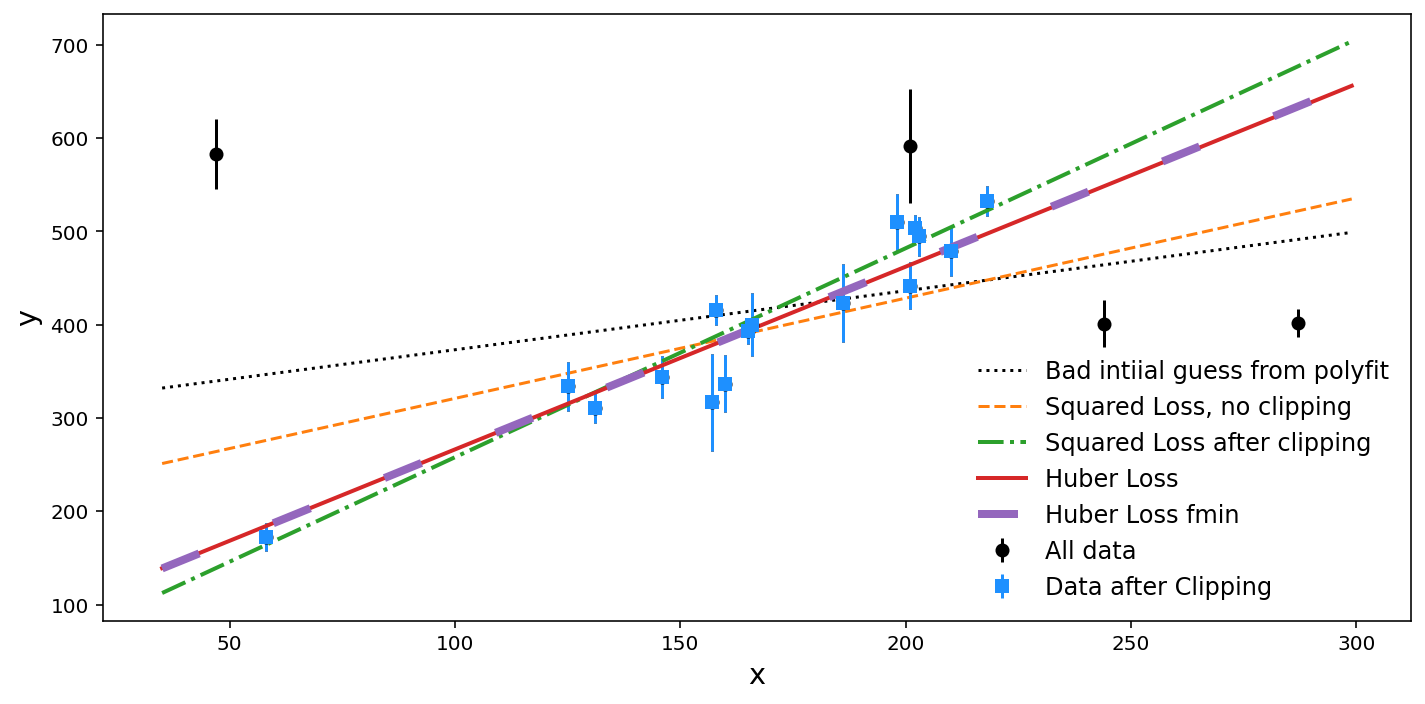

In [5]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# plot the data
ax.errorbar(x, y, yerr=dy, color='k', marker='o', linestyle='None', label='All data')
ax.set_xlabel('x', fontsize='x-large')
ax.set_ylabel('y', fontsize='x-large')

# we need to overplot other lines on our plot 
x_range = np.array(ax.get_xlim())

# plot the bad initial guess
ax.plot(x_range, line(slope_guess, intercept_guess, x_range), color='k',\
        linestyle=':', label='Bad intiial guess from polyfit')

# call our function with the squared loss

a_ssr, b_ssr, loss_ssr, i_a_ssr, i_b_ssr = eval_loss_func(x, y, dy, a_range, b_range, squared_loss)
ax.plot(x_range, line(a_ssr, b_ssr, x_range), color='C1', linestyle='--', label='Squared Loss, no clipping')


# next I asked you to clean up the data and use whatever you like:
# you can use this commented out solution

# from astropy.visualization import hist as ahist
# from astropy.stats import sigma_clip
# ahist(residual_squared_loss, bins='scott')
# clipped = sigma_clip(residual_squared_loss, sigma=1.5, masked=True)
# keep = ~clipped.mask

# or you can recognize that I am lazy and it's just the first 4 points in your text file that are outliers...
keep = np.ones(len(x), dtype='bool')
keep[0:4] = False

# lets highlight the data after clipping
ax.errorbar(x[keep], y[keep], yerr=dy[keep], color='DodgerBlue',\
            marker='s', linestyle='None', label='Data after Clipping')


# now we evaluate the same loss function on the clipped data
a_ssr_c, b_ssr_c, loss_ssr_c, i_a_ssr_c, i_b_ssr_c =\
    eval_loss_func(x[keep], y[keep], dy[keep], a_range, b_range, squared_loss)
ax.plot(x_range, line(a_ssr_c, b_ssr_c, x_range), color='C2', linestyle='-.', label='Squared Loss after clipping', lw=2)


# and then with the Huber loss
a_huber, b_huber, loss_huber, i_a_huber, i_b_huber = eval_loss_func(x, y, dy, a_range, b_range, huber_loss)
ax.plot(x_range, line(a_huber, b_huber, x_range), color='C3', linestyle='-', label='Huber Loss', lw=2)

# technically, I said evaluate the Huber loss with scipy.optimize.fmin
# this is just to get you used to using an optimizer rather than a grid
# and to force you to define a function that you can reuse with the first argument being an array
# Define the Huber loss function... again
def huber_loss2(theta, x, y, dy, delta):
    a = theta[0]
    b = theta[1]
    z = zres(a, b, x, y, dy)
    zabs = np.abs(z)
    loss = zabs*0.
    ind_out = (zabs > delta)
    loss[ind_out] = delta*zabs[ind_out] - delta**2./2.
    loss[~ind_out] = z[~ind_out]**2./2
    return np.sum(loss)

theta  = scipy.optimize.fmin(huber_loss2, [slope_guess, intercept_guess], args=(x, y, dy, 1.), )
a_huber2, b_huber2 = theta
ax.plot(x_range, line(a_huber2, b_huber2, x_range), color='C4', linestyle=(0, (5, 10)), label='Huber Loss fmin', lw=4)

ax.legend(frameon=False, fontsize='large')
fig.tight_layout()

/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1043: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1043: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "C2." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/gnarayan/miniconda3/envs/yse/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1043: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C2." (-> color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/gnarayan/miniconda3/envs/

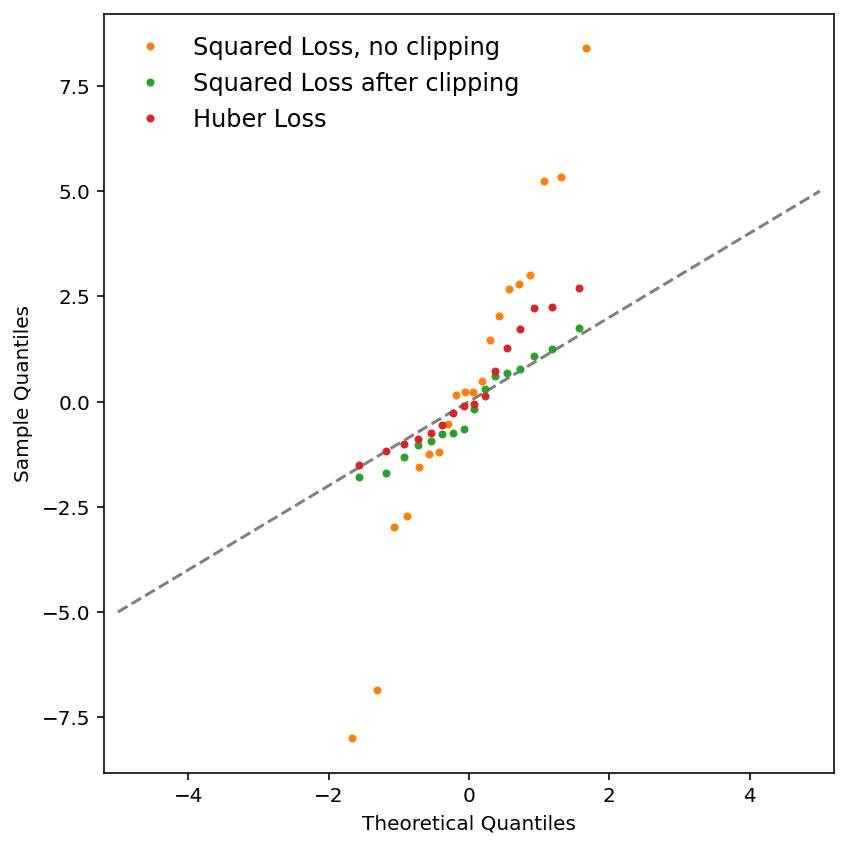

In [6]:
fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111)

# we already defined a function for the z-transformed data
zres_ssr_no_clip = zres(a_ssr, b_ssr, x, y, dy)
zres_ssr_clip    = zres(a_ssr_c, b_ssr_c, x[keep], y[keep], dy[keep])
zres_huber       = zres(a_huber, b_huber, x[keep], y[keep], dy[keep])

# it's easy to compare the fits with and without outliers here
ax2.plot([-5, 5], [-5, 5], 'k--', alpha=0.5)

sm.qqplot(zres_ssr_no_clip, ax=ax2, color='C1', marker='.', label='Squared Loss, no clipping')
sm.qqplot(zres_ssr_clip, fmt='C2.', ax=ax2, color='C2', marker='.', label='Squared Loss after clipping')
sm.qqplot(zres_huber, fmt='C3.', ax=ax2, color='C3', marker='.', label='Huber Loss')

# note that even the Huber and MLE fits are not perfet - the residuals show structure
ax2.legend(frameon=False, fontsize='large')
fig.tight_layout()

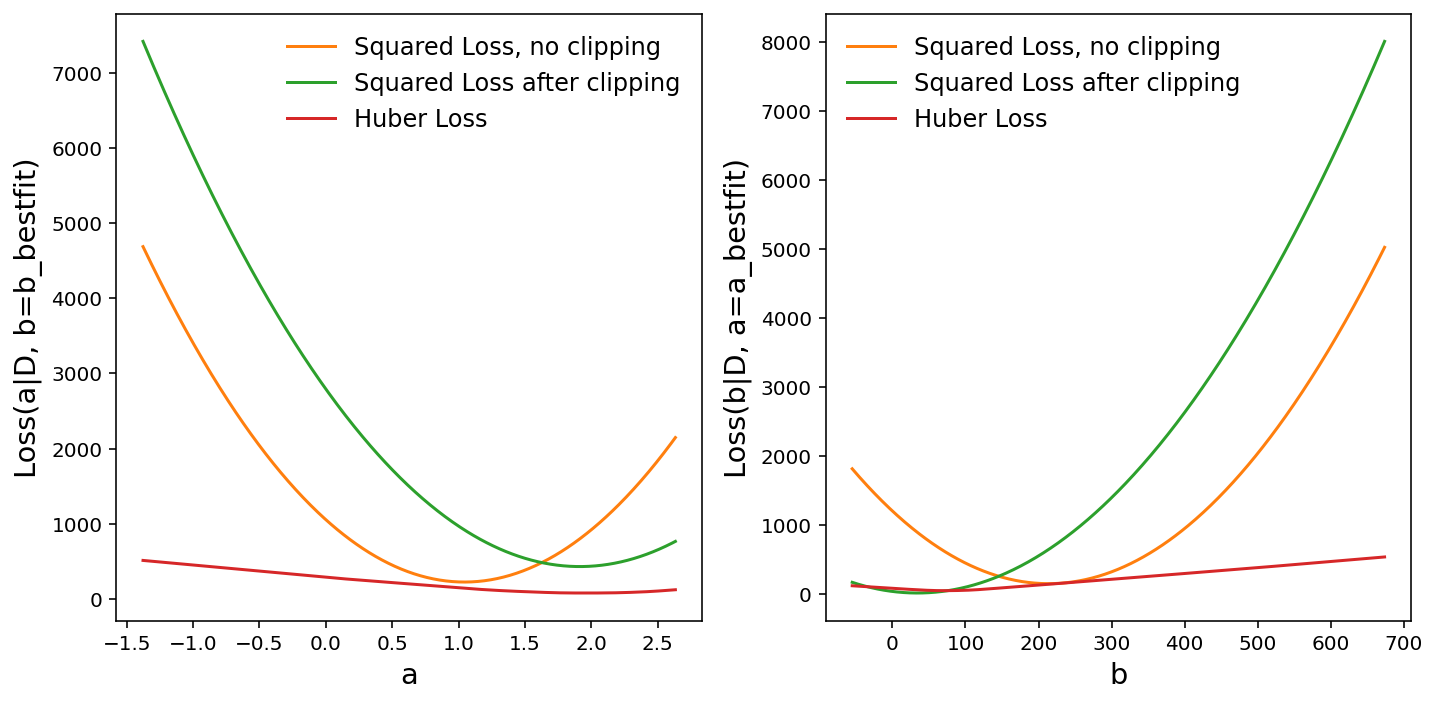

In [7]:
# it's easy to plot the marginal likelihoods in both slope and intercept

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# we already known the MLE values, so we simply look at the marginal likelihood at that location
ax1.plot(a_range, loss_ssr[:][i_b_ssr], color='C1', label='Squared Loss, no clipping')
ax1.plot(a_range, loss_ssr_c[:][i_b_ssr_c], color='C2', label='Squared Loss after clipping')
ax1.plot(a_range, loss_huber[:][i_b_huber], color='C3', label='Huber Loss')

ax2.plot(b_range, loss_ssr[i_a_ssr][:], color='C1', label='Squared Loss, no clipping')
ax2.plot(b_range, loss_ssr_c[i_a_ssr_c][:], color='C2', label='Squared Loss after clipping')
ax2.plot(b_range, loss_huber[i_a_huber][:], color='C3',  label='Huber Loss')

# Note how the likelihoods don't have the same location of the minimum
# and how the Huber loss weights outlying points much less - this is why the fit is more robust to them.

ax1.set_xlabel('a', fontsize='x-large')
ax2.set_xlabel('b', fontsize='x-large')
ax1.set_ylabel('Loss(a|D, b=b_bestfit)', fontsize='x-large')
ax2.set_ylabel('Loss(b|D, a=a_bestfit)', fontsize='x-large')

ax1.legend(frameon=False, fontsize='large')
ax2.legend(frameon=False, fontsize='large')

fig.tight_layout()

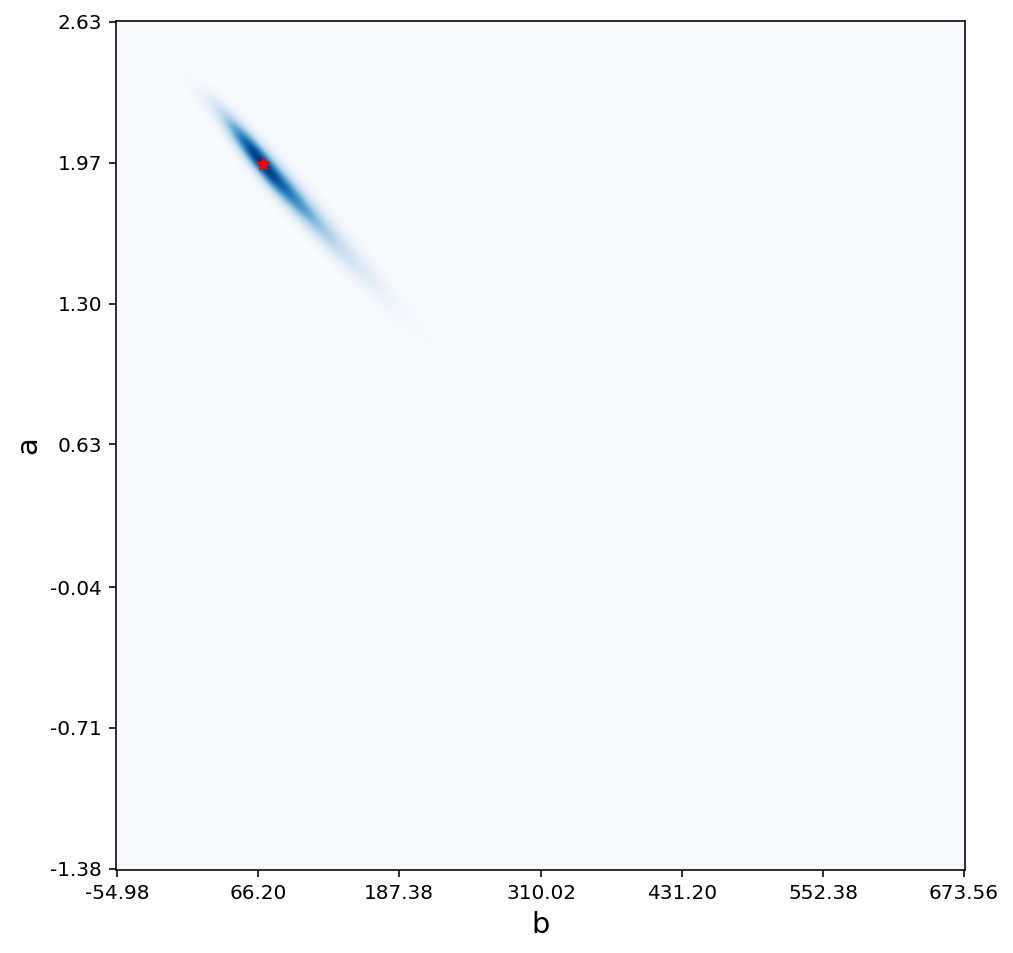

In [8]:


# you can also just plot the full loss - or likelihood surface:
fig = plt.figure(figsize=(7, 7))
ax3 = fig.add_subplot(1,1,1)

likelihood_huber = np.exp(-loss_huber)
ax3.imshow(likelihood_huber, origin='lower', cmap='Blues')

# the slope and intercept ranges are a_range and b_range, but we don't need to plot 500 points - 7 will do
a_idx = np.round(np.linspace(0, len(a_range) - 1, 7)).astype(int)
b_idx = np.round(np.linspace(0, len(b_range) - 1, 7)).astype(int)

# imshow uses 0 indexed values as coordinates - we can just use the indices for each array
ax3.set_xticks(b_idx)
ax3.set_yticks(a_idx)

# we can also format nice tick labels from the points corresponding to those indices
a_labels = [f'{y:.2f}' for y in a_range[a_idx]]
b_labels = [f'{x:.2f}' for x in b_range[b_idx]]

ax3.set_xticklabels(b_labels)
ax3.set_yticklabels(a_labels)

# and overplot the MLE value
ax3.scatter([i_b_huber,], [i_a_huber], color='r', marker='*')

ax3.set_xlabel('b', fontsize='x-large')
ax3.set_ylabel('a', fontsize='x-large')
fig.tight_layout()



## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

In [9]:
import pandas as pd
import warnings
warnings.simplefilter('ignore')
cep = pd.read_csv("Cepheids.csv")

In [10]:
lmcf = cep[(cep['Cloud'] == 'LMC') & (cep['Mode'] == 'F')]
smcf = cep[(cep['Cloud'] == 'SMC') & (cep['Mode'] == 'F')]

lmco = cep[(cep['Cloud'] == 'LMC') & (cep['Mode'] == '1')]
smco = cep[(cep['Cloud'] == 'SMC') & (cep['Mode'] == '1')]

In [11]:
cols = {'LMC':'C0', 'SMC':'C1'}
markers = {'F':'o', '1':'s'}
sample = [(lmcf, smcf), (lmco, smco)]


def get_col_marker(dfr):
    col = cols.get(dfr['Cloud'].iloc[0], 'k')
    marker = markers.get(dfr['Mode'].iloc[0], '^')
    title = '{:s} {:s}'.format(dfr['Cloud'].iloc[0], dfr['Mode'].iloc[0] )
    return col, marker, title

def plot_samp(s, ax1, ax2, alpha=0.1, ls='-'):
    col, marker, title = get_col_marker(s)
    ax1.scatter(s['logP1'], s['W'], color=col, marker=marker, alpha=alpha, label=title)
    slope_guess = 3.5
    intercept_guess = 15.5
    
    theta  = scipy.optimize.fmin(huber_loss2, [slope_guess, intercept_guess],\
                                 args=(s['logP1'], s['W'], 1., 1.), disp=False,full_output=False)
    m, c = theta
    
    label = fr'${m:.3f} \cdot x {c:+.3f}$'

    xvals = ax1.get_xlim()    
    def f(x):
        return m*np.array(x) + c
    
    ax1.plot(xvals, f(xvals), ls=ls, color='k', label=label)
    fitW = f(s['logP1'])
    r = s['W'] - fitW
    sm.qqplot(r, ax=ax2, color=col, marker=marker, alpha=alpha)
    ax2.plot([-3, 3], [-3, 3], color='k', ls=':')
    return r, fitW

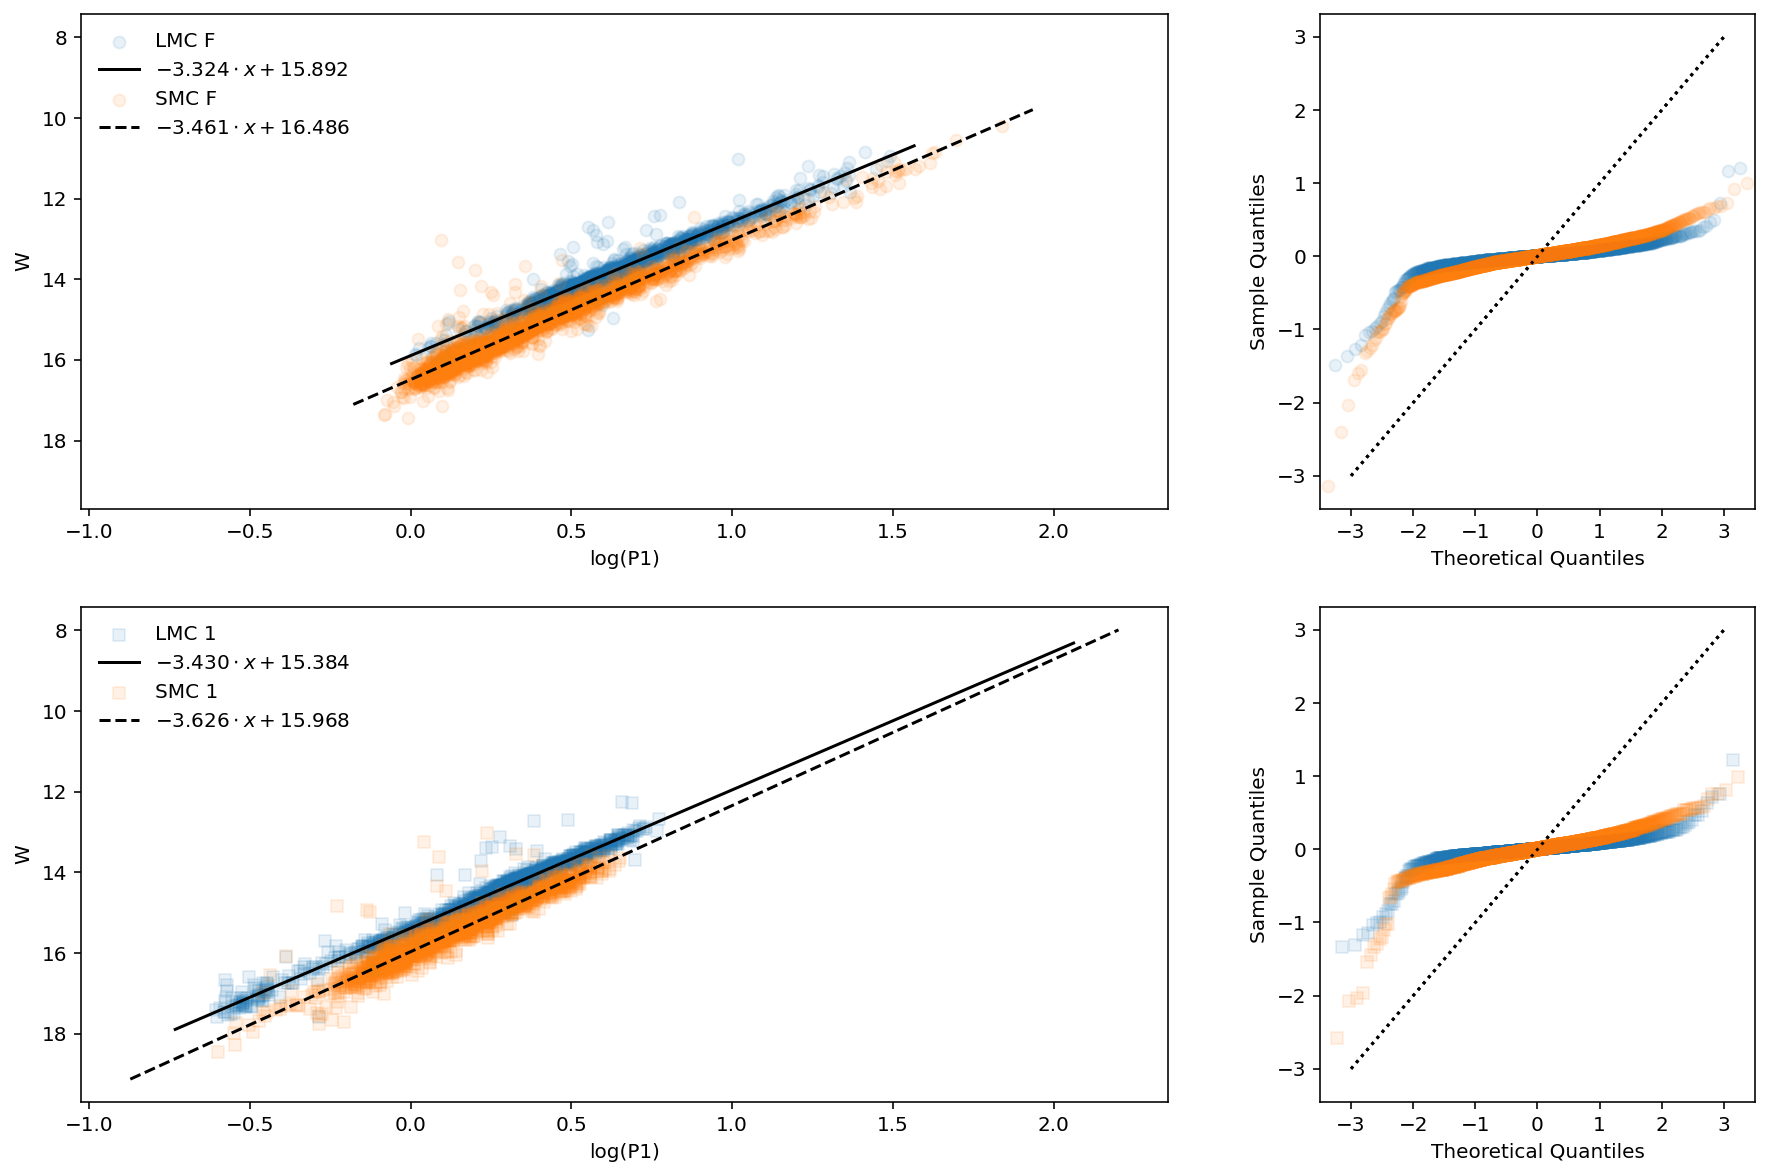

In [12]:
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[2.5,1], height_ratios=[1,1])

shareax1 = None
shareax2 = None
for i, samp in enumerate(sample):
    ax1 = fig.add_subplot(gs[i,0], sharex=shareax1, sharey=shareax1)
    ax2 = fig.add_subplot(gs[i,1], sharex=shareax2, sharey=shareax2)
    if shareax1 is None:
        shareax1 = ax1
        shareax2 = ax2
    
    ls = ['-','--']
    ax1.set_xlabel('log(P1)')
    ax1.set_ylabel('W')
    for j, s in enumerate(samp):
        r, fitW = plot_samp(s, ax1, ax2, ls=ls[j])
        s['resid'] = r
        s['fitW'] = fitW
    ax1.legend(frameon=False)
    
shareax1.invert_yaxis()

In [13]:
sample = [(lmcf, lmco), (smcf, smco)]
def plot_map(s, ax, alpha=0.1):
    _, marker, title = get_col_marker(s)
    col = ['C0' if x <=0 else 'C1' for x in s['resid']]
    ax.scatter(s['RA0'], s['Decl0'], color=col, marker=marker, alpha=alpha)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    cloud = title.split()[0]
    ax.set_title(cloud)

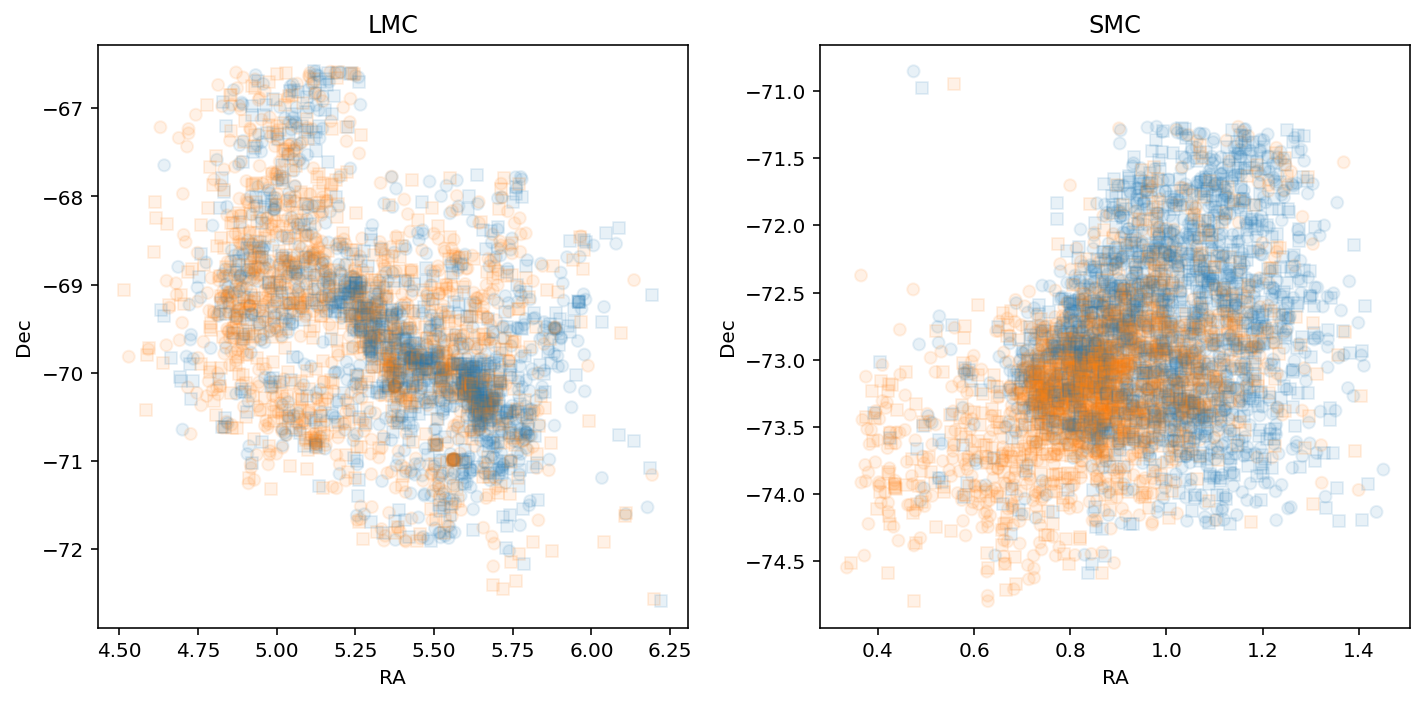

In [14]:
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1,1])
for i, samp in enumerate(sample):
    ax = fig.add_subplot(gs[i])
    for j, s in enumerate(samp):
        plot_map(s, ax)


fig.tight_layout()   

## Hey, that's kinda nifty - apparently the LMC and SMC know something about the sign of our fit residuals...

In [15]:
sample = [(lmcf, smcf), (lmco, smco)]
def plot_resids(s, ax, alpha=0.1):
    col, marker, title = get_col_marker(s)
    ax.scatter(s['fitW'], s['resid'], color=col, marker=marker, alpha=alpha, label=title)
    xvals = np.array(ax.get_xlim())
    ax.plot(xvals, [0,0], ls=':', color='k')
    ax.set_xlabel('fit W')
    ax.set_ylabel('Residual')
    ax.set_ylim(-1.5, 1.5)
    ax.legend()
    return

def hist_resids(s, ax, alpha=0.1):
    col, marker, title = get_col_marker(s)
    hist(s['resid'], color=col, bins='knuth', label=title, ax=ax, alpha=0.5, stacked=True, log=True)
    ax.set_xlabel('Residual')
    ax.legend()
    return

 
def plot_corr(s, ax, alpha=0.1, ls='-'):
    col, marker, title = get_col_marker(s)
    ax.scatter(s['VI'], s['logP1'], color=col, marker=marker, alpha=alpha)

    theta  = scipy.optimize.fmin(huber_loss2, [slope_guess, intercept_guess],\
                                args=(s['VI'], s['logP1'], 1., 1.), disp=False,full_output=False)
    m, c = theta

    label = fr'${m:.2f} \cdot x  {c:+.2f}$'
    xvals = ax.get_xlim()    
    def f(x):
        return m*np.array(x) + c
    
    ax.plot(xvals, f(xvals), ls=ls, color='k', label=label)
    ax.set_xlabel('V-I')
    ax.set_ylabel('log(P1)')

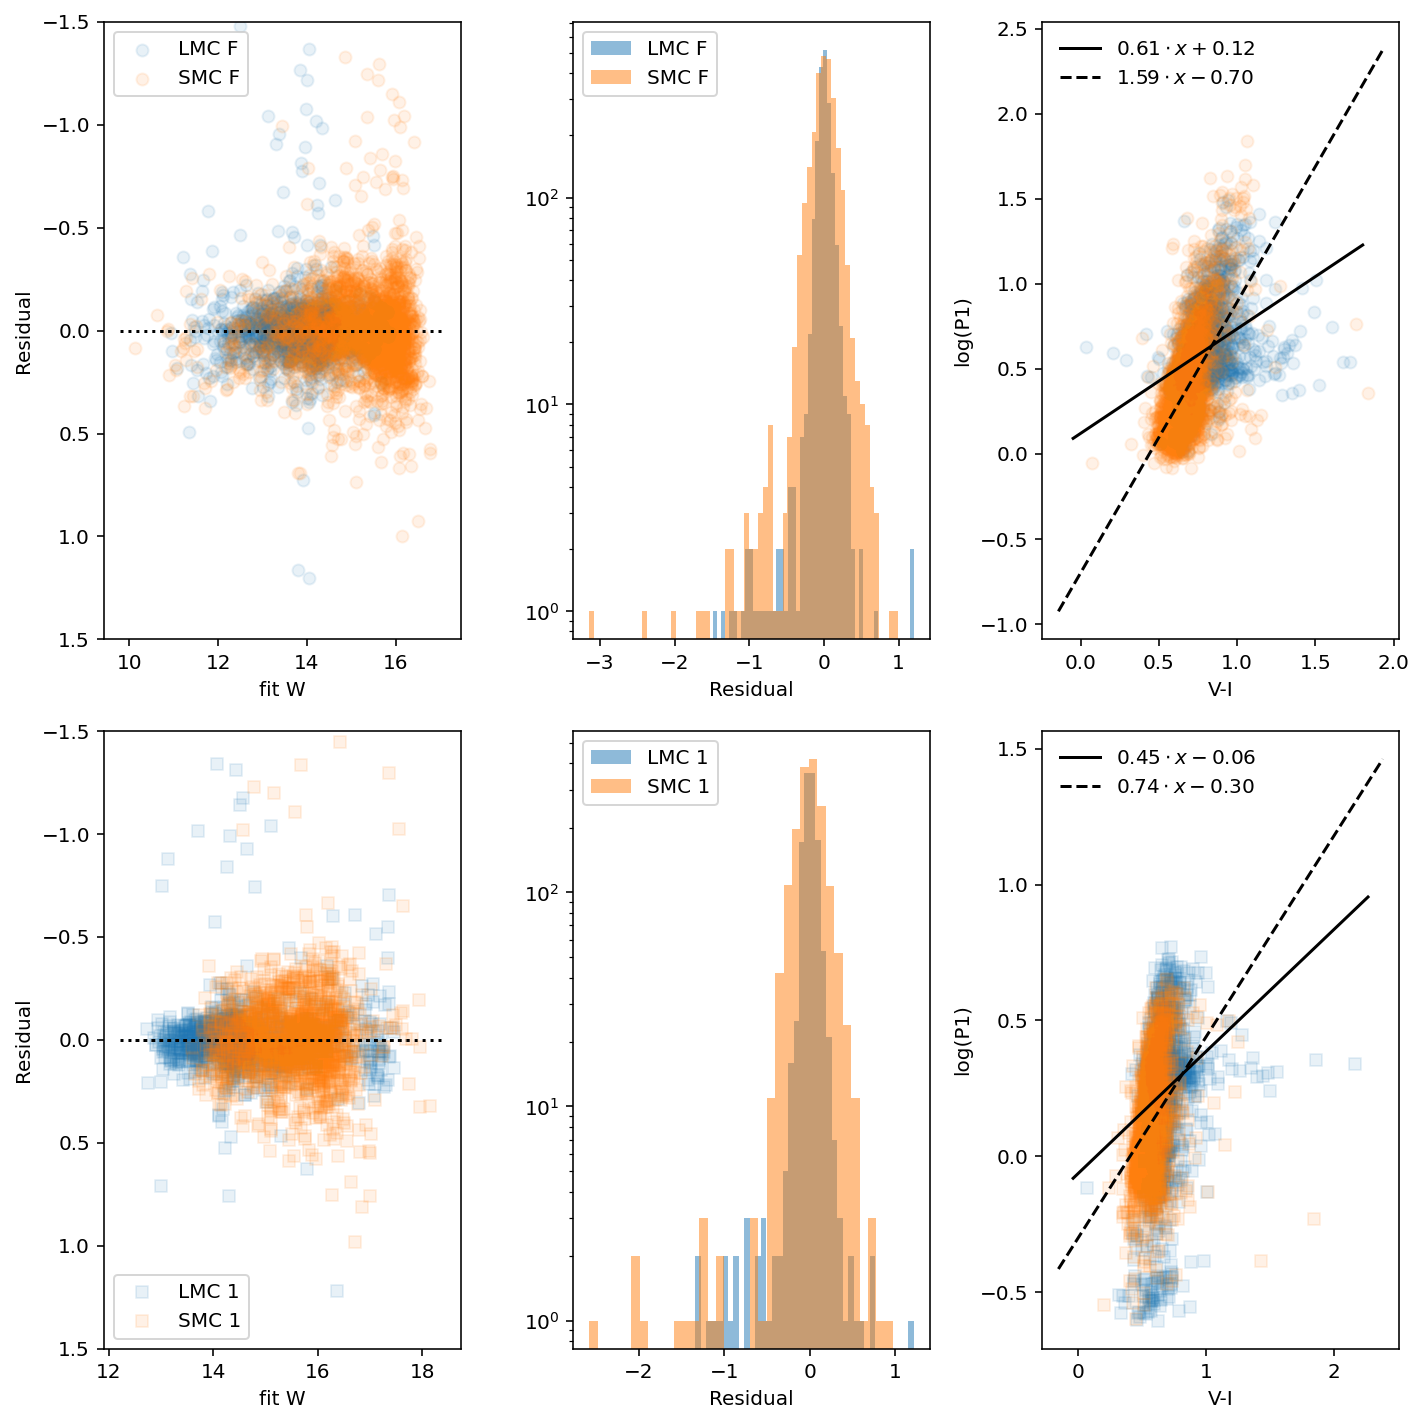

In [16]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(ncols=3, nrows=2, height_ratios=[1,1])
for i, samp in enumerate(sample):
    ax1 = fig.add_subplot(gs[i,0])
    ax2 = fig.add_subplot(gs[i,1])
    ax3 = fig.add_subplot(gs[i,2])
    ls = ['-','--']
    for j, s in enumerate(samp):
        plot_resids(s, ax1)
        hist_resids(s, ax2)
        plot_corr(s, ax3, ls=ls[j])
    ax3.legend(frameon=False)
    ax1.invert_yaxis()
fig.tight_layout()

## Not only are the residuals not normally distributed, they're assymetric - there's a bunch more objects that where the data is more negative that the fit (i.e. brighter) than there are positive (fainter) which is apparent if you change the histogram scaling to be lograthmic. 

## This is a selection bias.

## You wouldn't want to trust the regression coefficients for any relation between V-I and period without accounting for the selection bias - i.e. the population of stars you can't see.

## In fact, we're still not sure if the Cepehids in the LMC and SMC have a true Period-Luminosity-Color relation or if it's largely Period luminosity. We're still studying the Leavitt law.